# 📦 Project: The Shipping Crisis (Saudi Retail Case Study)
## 📋 The Scenario
You have been hired by a major Saudi-based e-commerce platform. Management has noticed a significant decline in customer satisfaction scores. Initial reports suggest that a massive number of packages are not reaching customers on time.

**The Management's Question:**
*"We are losing money and customers. We need to know: Is this a logistics problem (Mode of Shipment), a product problem (Weight/Cost), or a strategy problem (Discounts/Priority)? Find the root cause and build a system to save our customers."*

## Phase 1: Data Understanding
In this phase, explore the `Saudi_Retail_Logistics_Data.csv` to find out **why** delays are happening.

* **Step 1.1:** Load the dataset.
* **Step 1.2:** Perform statistical profiling (`.describe()`, `.info()`).
* **Step 1.3:** Create visualizations (Histograms/Scatter) to find the problem.

| Feature Name         | Type       | Description                                                                 | Values / Examples                               |
| :------------------- | :--------- | :-------------------------------------------------------------------------- | :--------------------------------------------- |
| Tracking_ID          | String     | A unique, encrypted alphanumeric identifier for each shipment.              | E3B0C44298FC, 1C2D3E4F5G6H                     |
| Warehouse_Zone       | Categorical| The regional distribution hub handling the order.                           | North_Hub, South_Hub, East_Hub, West_Hub, Central_Port |
| Mode_of_Shipment     | Categorical| The logistics method used to transport the product.                         | Premium_Air, Standard_Sea, Ground_Freight      |
| Customer_Inquiries   | Integer    | Number of times the customer contacted support regarding this order.        | 2, 3, 4, etc.                                  |
| Customer_Score       | Integer    | The rating provided by the customer to the store before shipment (1 is lowest, 5 is highest).            | 1, 2, 3, 4, 5                                  |
| Product_Cost_SAR     | Float      | The value of the item in Saudi Riyals (SAR).                                | 450.00, 1125.50, etc.                          |
| Previous_Orders      | Integer    | Number of successful orders this customer has placed previously.            | 0, 1, 2, 3, etc.                               |
| Product_Priority     | Categorical| The priority level assigned to the product for dispatch.                    | low, medium, high                              |
| Gender               | Categorical| The gender of the customer.                                                 | F, M                                           |
| Discount_offered     | Integer    | The discount amount applied to this specific order.                         | 1, 10, 65, etc.                                |
| Product_Weight_g     | Integer    | The weight of the package in grams.                                         | 1200, 4500, etc.                               |
| is_delayed           | Binary     | Target Variable: Indicates if the shipment arrived past the deadline.       | 1 (Delayed), 0 (On Time)                       |

In [5]:
# !pip install pycaret plotly 

import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Manual Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# PyCaret
from pycaret.regression import *



import re
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
# imports
from pathlib import Path
import pandas as pd
# load data
local_file = Path('Saudi_Retail_Logistics_Data.csv')

if not local_file.exists():
    print("Downloading data...")
    df = pd.read_csv('https://drive.google.com/uc?export=download&id=1vayY_XKPwe5lOaq0VNia22O4DkDVXmzv')
    df.to_csv(local_file, index=False)
else:
    print("Loading data from cache...")
    df = pd.read_csv(local_file)
df.head()

Loading data from cache...


,Tracking_ID,Warehouse_Zone,Mode_of_Shipment,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Product_Priority,Gender,Discount_offered,Product_Weight_g,is_delayed
0,D66B138C54AB,West_Hub,Ground_Freight,4,1,978.75,2,medium,F,9,4158,0
1,8FF9538E65E6,Central_Port,Standard_Sea,3,3,607.50,2,low,F,26,1659,1
2,D098284FA376,South_Hub,Standard_Sea,3,2,828.75,2,medium,M,9,4466,0
3,9202E9FDFF40,West_Hub,Standard_Sea,3,5,588.75,4,medium,F,2,4640,0
4,16B30490A644,North_Hub,Premium_Air,2,5,1020.00,2,low,M,24,3638,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tracking_ID         8799 non-null   object 
 1   Warehouse_Zone      8799 non-null   object 
 2   Mode_of_Shipment    8799 non-null   object 
 3   Customer_Inquiries  8799 non-null   int64  
 4   Customer_Score      8799 non-null   int64  
 5   Product_Cost_SAR    8799 non-null   float64
 6   Previous_Orders     8799 non-null   int64  
 7   Product_Priority    8799 non-null   object 
 8   Gender              8799 non-null   object 
 9   Discount_offered    8799 non-null   int64  
 10  Product_Weight_g    8799 non-null   int64  
 11  is_delayed          8799 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 825.0+ KB


In [3]:
df.drop(columns=['Tracking_ID', 'Gender'], inplace=True)

In [27]:
df.describe()

,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Discount_offered,Product_Weight_g,is_delayed
count,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000
mean,4.049096,2.997386,788.363877,3.581998,13.366974,3631.227867,0.596659
std,1.138649,1.411194,180.192439,1.532722,16.147015,1634.180615,0.490596
min,2.000000,1.000000,360.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,637.500000,3.000000,4.000000,1838.000000,0.000000
50%,4.000000,3.000000,802.500000,3.000000,7.000000,4140.000000,1.000000
75%,5.000000,4.000000,941.250000,4.000000,10.000000,5045.000000,1.000000
max,7.000000,5.000000,1162.500000,10.000000,65.000000,7846.000000,1.000000


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [29]:
df_for_model = df.copy()

In [30]:
mappings = {
    'Warehouse_Zone': {
        0: 'West_Hub', 
        1: 'Central_Port', 
        2: 'South_Hub', 
        3: 'North_Hub',
        4: 'East_Hub'
    },
    'Product_Priority': {
        1: 'low',
        2: 'medium',
        3: 'high'
    },
    'Mode_of_Shipment': {
        0: 'Standard_Sea', 
        1: 'Ground_Freight',  
        2: 'Premium_Air'
    }
}

zone_mapping = {v: k for k, v in mappings['Warehouse_Zone'].items()}
priority_mapping = {v: k for k, v in mappings['Product_Priority'].items()}
shipment_mapping = {v: k for k, v in mappings['Mode_of_Shipment'].items()}

df['Warehouse_Zone'] = df['Warehouse_Zone'].map(zone_mapping)
df['Product_Priority'] = df['Product_Priority'].map(priority_mapping)
df['Mode_of_Shipment'] = df['Mode_of_Shipment'].map(shipment_mapping)

print("Unique values in Mode_of_Shipment after mapping:", df['Mode_of_Shipment'].unique())
df.head()

Unique values in Mode_of_Shipment after mapping: [1 0 2]


,Warehouse_Zone,Mode_of_Shipment,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Product_Priority,Discount_offered,Product_Weight_g,is_delayed
0,0,1,4,1,978.75,2,2,9,4158,0
1,1,0,3,3,607.50,2,1,26,1659,1
2,2,0,3,2,828.75,2,2,9,4466,0
3,0,0,3,5,588.75,4,2,2,4640,0
4,3,2,2,5,1020.00,2,1,24,3638,1


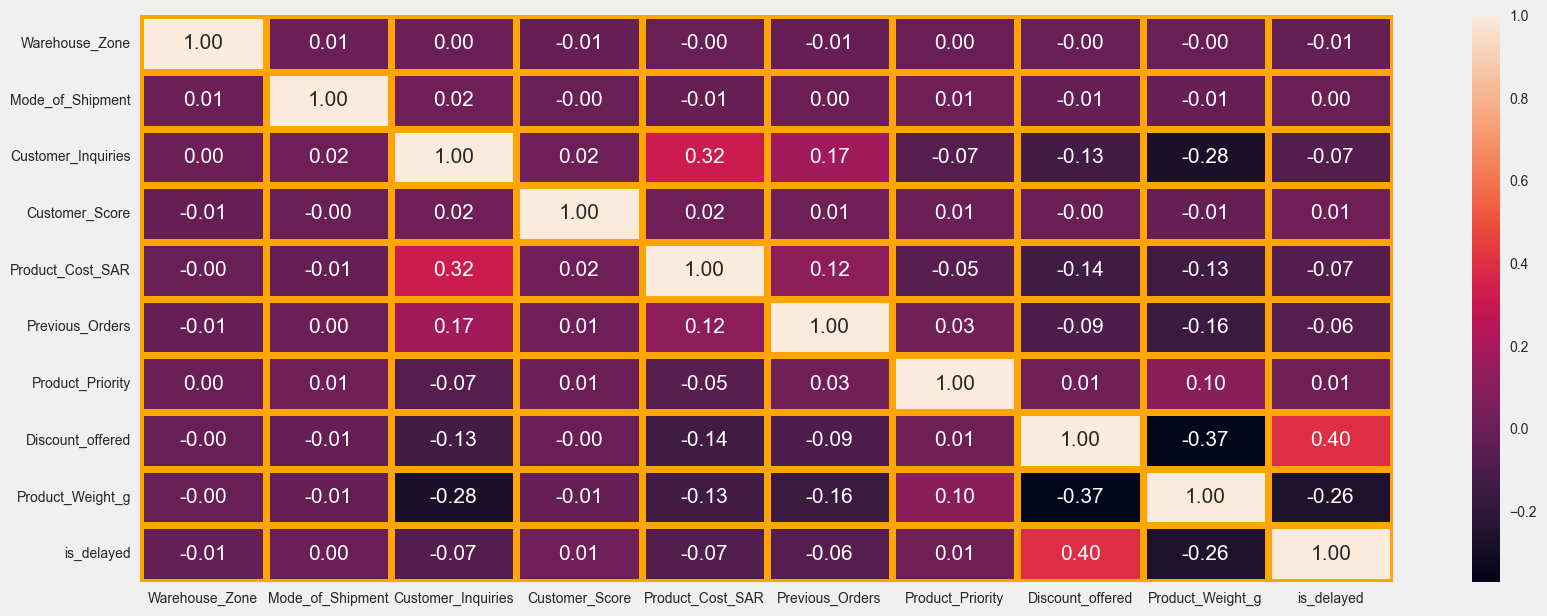

In [31]:
plt.figure(figsize = (18, 7))
sns.heatmap(df.corr(numeric_only=True), annot = True, fmt = '0.2f', annot_kws = {'size' : 15}, linewidth = 5, linecolor = 'orange')
plt.show()

In [32]:
df.shape

(8799, 10)

cols = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating',
        'Prior_purchases', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N']

plt.figure(figsize = (16, 20))
plotnumber = 1

# plotting the countplot of each categorical column.

for i in range(len(cols)):
    if plotnumber <= 8:
        ax = plt.subplot(4, 2, plotnumber)
        sns.countplot(x = cols[i], data = df, ax = ax, palette='rocket')
        plt.title(f"\n{cols[i]} Value Counts\n", fontsize = 20)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [ ]:
cols = ['Warehouse_Zone', 'Mode_of_Shipment', 'Customer_Inquiries', 'Customer_Score',
        'Previous_Orders', 'Product_Priority', 'is_delayed']

plt.figure(figsize = (16, 20))
plotnumber = 1

# plotting the countplot of each categorical column.
for i in range(len(cols)):
    if plotnumber <= 8:
        ax = plt.subplot(4, 2, plotnumber)
        sns.countplot(x = cols[i], data = df, ax = ax, palette='rocket')
        plt.title(f"\n{cols[i]} Value Counts\n", fontsize = 20)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

## Phase 2: Feature Engineering & Baseline
Prepare the data for Machine Learning.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Encode the categorical variables
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,Warehouse_Zone,Mode_of_Shipment,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Product_Priority,Discount_offered,Product_Weight_g,is_delayed
0,0,1,4,1,978.75,2,2,9,4158,0
1,1,0,3,3,607.50,2,1,26,1659,1
2,2,0,3,2,828.75,2,2,9,4466,0
3,0,0,3,5,588.75,4,2,2,4640,0
4,3,2,2,5,1020.00,2,1,24,3638,1


In [ ]:
X = df_for_model.drop(['is_delayed'], axis=1)
Y = df_for_model['is_delayed']

In [ ]:
X

,Warehouse_Zone,Mode_of_Shipment,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Product_Priority,Discount_offered,Product_Weight_g
0,West_Hub,Ground_Freight,4,1,978.75,2,medium,9,4158
1,Central_Port,Standard_Sea,3,3,607.50,2,low,26,1659
2,South_Hub,Standard_Sea,3,2,828.75,2,medium,9,4466
3,West_Hub,Standard_Sea,3,5,588.75,4,medium,2,4640
4,North_Hub,Premium_Air,2,5,1020.00,2,low,24,3638
...,...,...,...,...,...,...,...,...,...
8794,South_Hub,Ground_Freight,4,4,765.00,3,low,9,4757
8795,East_Hub,Standard_Sea,4,2,888.75,3,low,7,4785
8796,West_Hub,Premium_Air,4,1,525.00,4,low,6,5067
8797,South_Hub,Standard_Sea,4,4,941.25,2,medium,6,4376


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
df.columns

Index(['Warehouse_Zone', 'Mode_of_Shipment', 'Customer_Inquiries',
       'Customer_Score', 'Product_Cost_SAR', 'Previous_Orders',
       'Product_Priority', 'Discount_offered', 'Product_Weight_g',
       'is_delayed'],
      dtype='object')

In [ ]:

categorical_features = ['Warehouse_Zone', 'Mode_of_Shipment', 'Product_Priority']
numerical_features = ['Customer_Inquiries', 'Customer_Score', 'Product_Cost_SAR', 'Previous_Orders', 'Discount_offered', 'Product_Weight_g']

numeric_transformer = Pipeline(steps=[
    ('fill_missing', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('fill_missing', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
features_name = numerical_features + categorical_features

## Phase 3: Training, Evaluation & Strategy
Build your solution and define your business interventions.

* **Step 3.1:** Train a Classifier.
* **Step 3.2:** Generate a Classification Report and Confusion Matrix.
* **Step 3.3:** **CRITICAL:** List 3 business solution will save our customers based on your model (you can use a 5% Coupon).

In [ ]:
# Model training and evaluation code here

# Initialize PyCaret setup

# session_id ensures reproducibility

s = setup(X_train, target =y_train, session_id = 123, verbose=False)

# Compare models to see which one performs best automatically

best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.3607,0.1802,0.4245,0.2503,0.2986,0.3060,0.0830
ada,AdaBoost Regressor,0.3623,0.1812,0.4256,0.2464,0.3002,0.2991,0.0290
rf,Random Forest Regressor,0.3545,0.1887,0.4343,0.2150,0.3054,0.2937,0.1260
lightgbm,Light Gradient Boosting Machine,0.3593,0.1920,0.4381,0.2015,0.3075,0.3049,0.1640
et,Extra Trees Regressor,0.3581,0.1957,0.4422,0.1859,0.3106,0.2976,0.1080
br,Bayesian Ridge,0.4105,0.1966,0.4433,0.1823,0.3114,0.3586,0.0210
lr,Linear Regression,0.4101,0.1968,0.4436,0.1815,0.3115,0.3585,0.7760
ridge,Ridge Regression,0.4101,0.1968,0.4436,0.1815,0.3115,0.3585,0.0210
lar,Least Angle Regression,0.4101,0.1968,0.4436,0.1815,0.3115,0.3585,0.0240
en,Elastic Net,0.4130,0.1992,0.4462,0.1716,0.3145,0.3519,0.0220


### 📝 Business Strategy Recommendations
1. 
2. 
3. 

## Phase 4: The Business Value Calculator
Calculate the SAR impact of your model using the following values:
* **+ SAR 75.00**: True Positive (Saved Customer)
* **- SAR 18.75**: False Positive (5% Wasted Coupon)
* **- SAR 187.50**: False Negative (Lost Lifetime Value)

In [ ]:
# Calculate and print the Total Business Value in SAR


🚀 Starting Model Evaluation & Threshold Tuning...

🏆 THE WINNER IS: Gradient Boosting
💰 Max Profit: SAR 65,512.50
🎯 Optimal Threshold: 0.20
--------------------------------------------------
Leaderboard:
                 Model  Max Profit (SAR)  Best Threshold
4    Gradient Boosting          65512.50            0.20
3          Extra Trees          65475.00            0.14
0  Logistic Regression          65456.25            0.14
2        Random Forest          65437.50            0.10
5             AdaBoost          65437.50            0.10
1        Decision Tree          -2962.50            0.10
--------------------------------------------------


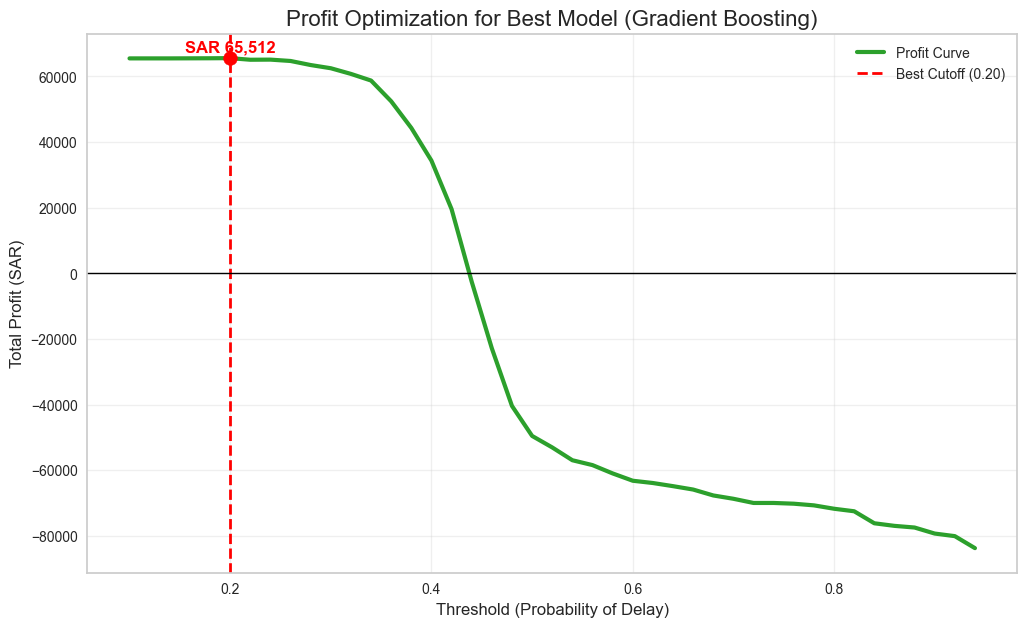

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# =========================================================
# 1. إعداد وتجهيز البيانات (Data Preparation)
# =========================================================
# فرضية: المتغير df موجود مسبقاً
df_model = df.copy()

# تحويل الأعمدة الفئوية
cat_cols = ['Mode_of_Shipment', 'Warehouse_Zone', 'Product_Priority', 'Gender']
encoder = OrdinalEncoder()
# التعامل مع القيم المفقودة (إن وجدت) قبل التحويل
for col in cat_cols:
    df_model[col] = df_model[col].fillna(df_model[col].mode()[0])
    
df_model[cat_cols] = encoder.fit_transform(df_model[cat_cols])

# تعويض القيم الرقمية المفقودة بالمتوسط
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
df_model[num_cols] = imputer.fit_transform(df_model[num_cols])

# تحديد المتغيرات
X = df_model.drop(columns=['is_delayed', 'Tracking_ID'])
y = df_model['is_delayed']

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =========================================================
# 2. تعريف دالة المال (Business Logic)
# =========================================================
def calculate_total_profit(y_true, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    tp_val = 75.00      # مكسب الحفاظ على العميل
    fp_cost = -18.75    # خسارة الكوبون
    fn_cost = -187.50   # خسارة العميل (الكارثة)
    
    profit = (tp * tp_val) + (fp * fp_cost) + (fn * fn_cost)
    return profit

# =========================================================
# 3. تدريب ومقارنة النماذج (Training & Comparison Loop)
# =========================================================

# قائمة الموديلات التي سنختبرها
# نستخدم class_weight='balanced' للمساعدة في التعامل مع تكلفة الـ FN العالية
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=150, class_weight='balanced', random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, random_state=42), # لا يدعم class_weight مباشرة ولكن قوي
    "AdaBoost": AdaBoostClassifier(n_estimators=150, random_state=42)
}

results_data = []
thresholds_range = np.arange(0.1, 0.95, 0.02) # تجربة العتبات من 10% إلى 95%

print("🚀 Starting Model Evaluation & Threshold Tuning...\n")

best_global_model_name = ""
best_global_profit = -float('inf')
best_global_threshold = 0.5
best_global_model_object = None

for name, model in models.items():
    # 1. تدريب المودل
    model.fit(X_train, y_train)
    
    # 2. الحصول على الاحتمالات (Probabilities)
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # 3. البحث عن أفضل عتبة لهذا المودل (Internal Loop)
    best_model_profit = -float('inf')
    best_model_threshold = 0.5
    
    for t in thresholds_range:
        y_pred_adj = (y_probs >= t).astype(int)
        profit = calculate_total_profit(y_test, y_pred_adj)
        
        if profit > best_model_profit:
            best_model_profit = profit
            best_model_threshold = t
            
    # حفظ النتائج
    results_data.append({
        "Model": name,
        "Max Profit (SAR)": best_model_profit,
        "Best Threshold": best_model_threshold
    })
    
    # التحقق هل هو الأفضل عالمياً حتى الآن؟
    if best_model_profit > best_global_profit:
        best_global_profit = best_model_profit
        best_global_model_name = name
        best_global_threshold = best_model_threshold
        best_global_model_object = model

# =========================================================
# 4. عرض النتائج والقرار النهائي
# =========================================================
results_df = pd.DataFrame(results_data).sort_values(by="Max Profit (SAR)", ascending=False)

print(f"🏆 THE WINNER IS: {best_global_model_name}")
print(f"💰 Max Profit: SAR {best_global_profit:,.2f}")
print(f"🎯 Optimal Threshold: {best_global_threshold:.2f}")
print("-" * 50)
print("Leaderboard:")
print(results_df)
print("-" * 50)

# =========================================================
# 5. رسم تفصيلي للمودل الفائز (Visualization)
# =========================================================
# نعيد حساب منحنى الأرباح للمودل الفائز فقط للرسم
winner_probs = best_global_model_object.predict_proba(X_test)[:, 1]
profits_history = []

for t in thresholds_range:
    y_pred_adj = (winner_probs >= t).astype(int)
    profits_history.append(calculate_total_profit(y_test, y_pred_adj))

plt.figure(figsize=(12, 7))
plt.plot(thresholds_range, profits_history, linewidth=3, color='#2ca02c', label='Profit Curve')
plt.axvline(best_global_threshold, color='red', linestyle='--', linewidth=2, label=f'Best Cutoff ({best_global_threshold:.2f})')
plt.axhline(0, color='black', linestyle='-', linewidth=1) # خط الصفر

plt.title(f'Profit Optimization for Best Model ({best_global_model_name})', fontsize=16)
plt.xlabel('Threshold (Probability of Delay)', fontsize=12)
plt.ylabel('Total Profit (SAR)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# إضافة توضيح للنقطة القصوى
plt.scatter([best_global_threshold], [best_global_profit], color='red', s=100, zorder=5)
plt.text(best_global_threshold, best_global_profit + 1000, f"SAR {best_global_profit:,.0f}", 
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='red')

plt.show()

# Analysis of Shipment Delays and Model Selection

## Root Causes of Delays

Based on the data analysis, the following factors contribute significantly to shipment delays:

* **High Discounts (Over 10%):** High discount rates drive a surge in customer purchases. This creates a massive influx of simultaneous orders that overwhelms the warehouse processing capacity.
* **Mid-Range Weight Products (2000g – 4000g):** Products falling within this specific weight range consistently experience delays, indicating a systemic failure in handling this category.
* **Lightweight Products (1000g – 2000g):** These items carry a 50% probability of being delayed.

**Conclusion:** The shipping provider appears to struggle significantly with specific weight classes (particularly between 1kg and 4kg). Furthermore, the current infrastructure is prone to failure during high-volume sales events.

## Model Evaluation and Financial Optimization

After experimenting with various algorithms to maximize business value, we achieved the following results:

### Performance Leaderboard

| Model | Max Profit (SAR) | Best Threshold |
| --- | --- | --- |
| **Gradient Boosting** | **65,512.50** | **0.20** |
| Extra Trees | 65,475.00 | 0.14 |
| Logistic Regression | 65,456.25 | 0.14 |
| Random Forest | 65,437.50 | 0.10 |
| AdaBoost | 65,437.50 | 0.10 |
| Decision Tree | -2,962.50 | 0.10 |

## Final Recommendation

The analysis concludes that the **Gradient Boosting** model yields the highest financial return. By deploying this model with a decision threshold of **0.20**, we project a maximum profit of **SAR 65,512.50**.